In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
c   = 2.9979245800e+10 # Speed of light in CGS, in SI e-11
G   = 6.6741840000e-08 # Gravitational constant in CGS, in SI e-11
h   = 1.0545718000e-27 # Planck constant with dash in CGS, in SI e-34
m_p = 1.6726218980e-24 # Proton mass in CGS, in SI e-27
m_e = 9.1093835600e-28 # Electron mass in CGS, in SI e-31

In [7]:
def solver(solver_step, t_start, y_start, funcs, dt=1e-2):
    t = t_start
    y = y_start.copy()
    res = [] #y
    #print('Start solve by: ', solver_step.__name__)
    while y[1] >= 0.0 and not np.isnan(y[1]) and not np.isinf(y[1]):
        res.append(y)
        y = solver_step(dt, t, y, funcs)
        
        
        t = t + dt
        
        #print('.', end='')
    #print('Solved')    
    return t, np.array(res)

def euler_koshi_step(dt, t, y, funcs):
    y1 = np.zeros(len(funcs))
    ny = np.zeros(len(funcs))
    for (i, f) in enumerate(funcs):
        y1[i] = y[i] + dt * f(t, y)
    
    for (i, f) in enumerate(funcs):
        ny[i] = y[i] + dt * (f(t, y) + f(t + dt, y1)) / 2.0
    
    return ny

def rk_4_step(dt, t, y, funcs):
    sz = len(funcs)
    ny = np.zeros((sz,), dtype=np.float64)#[None] * sz
    
    two = float(2.0)
    
    k1 = np.array([dt * f(t, y) for f in funcs], dtype=np.float64)
    y1 = y + k1 / two #np.array([(y[i] + k1[i] / 2.0) for i in range(sz) ])
    #print(y1, (y + k1 / 2.0))
    t1 = (t + dt / two)
    
    k2 = np.array([dt * f(t1, y1) for f in funcs], dtype=np.float64)
    y2 = y + k2 / two #[(y[i] + k2[i] / two) for i in range(sz) ] #
    t2 = t1
    
    k3 = np.array([dt * f(t2, y2) for f in funcs], dtype=np.float64)
    y3 = y + k3 #[(y[i] + k3[i]) for i in range(sz) ]
    t3 = (t + dt)
    
    k4 = np.array([dt * f(t3, y3) for f in funcs], dtype=np.float64)
    
    for (i, f) in enumerate(funcs):
        ny[i] = y[i] + ( k1[i] + k4[i] + two * (k2[i] + k3[i]) ) / float(6.0)
    return ny

<h1>White Dwarf</h1>

0.04776886922879861
[3.70370370e-08 1.01933171e+00]
2.5365269560492063


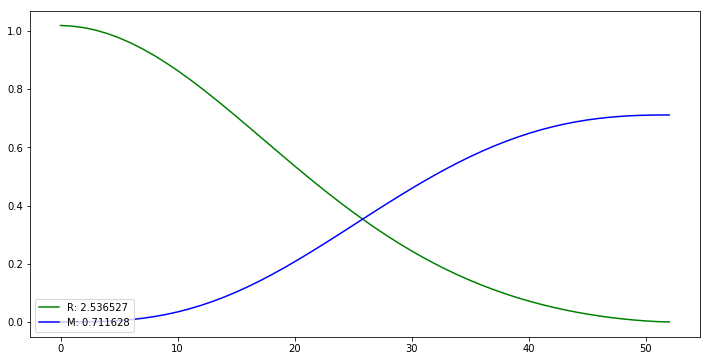

In [26]:
def psi(p):
    #print(p)
    if p <= 0.0 or np.isnan(p) or np.isinf(p):
        return np.inf
    x = np.power(p, 2.0/float(3.0), dtype=np.float64)
#    if np.isnan(x):
#        return np.inf
    #x2 = np.power(x, 2)
    return x / 3.0 / np.sqrt(1 + x)

funcs = [
    lambda r, y: y[1] * r**2, # dm/dr = p * r^2
    lambda r, y: -y[0] * y[1] / r**2 / psi(y[1]), # dp/dr = -m * p / psi / r^2
]

n0 = ((m_e*c/h) ** 3) / (3*(np.pi ** 2)) # Does not depend on anything
betta = 1#26.0/56.0
po0 = m_p*n0/betta

Pc = 1e6

Pc = Pc / float(po0)

dr = 1.0/float(3.0) * np.power(3e-3 / float(Pc), 1.0/float(3.0))

#dr = 0.33333*((0.003/Pc) ** 0.333333)#0.001
print(dr)

r0 = dr / float(10.0)

P0 = Pc - 1.0/float(6.0) * np.power(Pc * r0, 2) / psi(Pc)

m0 = Pc/float(3.0) * np.power(r0, 3)

y0 = np.array([m0, P0], dtype=np.float64)

print(y0)

R_rk4, result_rk4 = solver(rk_4_step, r0, y0, funcs=funcs, dt=dr)

R_euler, result_ek = solver(euler_koshi_step, r0, y0, funcs=funcs, dt=dr)

#print(np.array(result_rk4) - np.array(result_ek[:-1]))
#print(result_ek, "\n\n", result_rk4)

print(R_rk4)

plt.figure(figsize=(12, 6))
plt.plot(range(len(result_rk4[:,1])), result_rk4[:,1], color='green', label='R: {:f}'.format(R_rk4))
plt.plot(range(len(result_rk4[:,0])), result_rk4[:,0], color='blue', label='M: {:f}'.format(result_rk4[-1,0]))

#plt.plot(result_ek[:,0], result_ek[:,1], color='orange', label='P/m euler: {:f}'.format(R_euler))

#plt.plot(rk4_res_x, rk4_res_y, color='green', label='rk_4_step')
plt.legend(loc="lower left")
plt.show()


In [87]:
def compute_dwarfs(dimensionless_center_density_array):
    
    radius_array = []
    mass_array = []
    density_array = []
    
    for Pc in dimensionless_center_density_array:
        
        dr = 1.0/float(3.0) * np.power(3e-3 / float(Pc), 1.0/float(3.0))
        r0 = dr / float(10.0)

        m_r0 = Pc/float(3.0) * np.power(r0, 3)
        po_r0 = Pc - 1.0/float(6.0) * np.power(Pc * r0, 2) / psi(Pc)
        y0 = np.array([m_r0, po_r0], dtype=np.float64)

        R_rk4, result_rk4 = solver(rk_4_step, r0, y0, funcs=funcs, dt=dr)

        m = result_rk4[-1,0]
        po = result_rk4[-1,1]
        
        #R_rk4 = r0 + dr * len(result_rk4[:,0])
        
        #R_rk4 = r0 + np.arange(len(result_rk4[:,0]))*dr
        
        radius_array.append(R_rk4)
        mass_array.append(m)
        density_array.append(po)
    
    return radius_array, mass_array, density_array

In [90]:
dimensionless_center_density_array = 1e-6*np.exp(np.arange(60)*0.6931471806) / float(po0)

radius_array, mass_array, density_array = compute_dwarfs(dimensionless_center_density_array)

po = dimensionless_center_density_array
m = np.array(mass_array)
r = np.array(radius_array)#[::-1]

print("Min parameter: {}, Max parameter: {}".format(np.min(po), np.max(po)))
print("Min radius: {}, Max raduis: {}".format(np.min(r), np.max(r)))
print("Min mass: {}, Max mass: {}".format(np.min(m), np.max(m)))

Min parameter: 1.0193483114225477e-12, Max parameter: 587614.2958505315
Min radius: 0.07926510837596028, Max raduis: 525.4575615167845
Min mass: 3.7037037037036983e-08, Max mass: 2.016676817861373


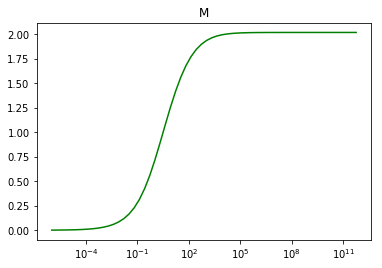

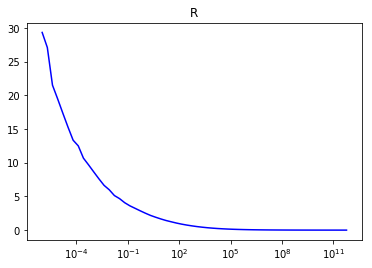

In [89]:
plt.figure()
plt.title("M")
plt.xscale('log')
plt.plot(po, m, 'g')
plt.show()

plt.figure()
plt.title("R")
plt.xscale('log')
plt.plot(po, (r), 'b')

#plt.legend(loc="lower left")
plt.show()
